In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import pearsonr
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
sen_pairs = pd.read_csv('./sent2vec/sentence_pairs.csv')
sen_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 6 columns):
sentenceA                                                                      555 non-null object
sentenceB                                                                      555 non-null object
if_sentence_a_is_true_then                                                     555 non-null object
to_what_extent_are_the_two_sentences_expressing_a_related_meaning              555 non-null float64
to_what_extent__are_the_two_sentences_expressing_a_related_meaning:variance    555 non-null float64
Unnamed: 5                                                                     1 non-null float64
dtypes: float64(3), object(3)
memory usage: 26.1+ KB


C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


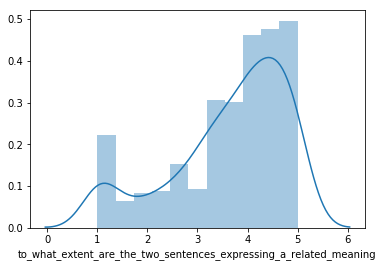

In [3]:
sns.distplot(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning)

## Basic Matching

In [4]:
def get_distance_jaccard(sen1, sen2):
    sen1 = sen1.lower()
    sen2 = sen2.lower()
    sen1 = set(sen1.split(" "))
    sen2 = set(sen2.split(" "))
    return float(len(sen1 & sen2))/(len(sen1 | sen2))

In [5]:
sen_pairs['dist_jaccard'] = sen_pairs.apply(lambda row: get_distance_jaccard(row['sentenceA'],row['sentenceB']), axis=1)
pearsonr(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, 
            sen_pairs['dist_jaccard'])

(0.61916838528662521, 4.7779090655514145e-60)

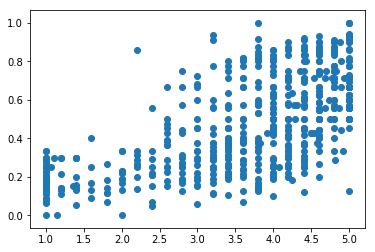

In [6]:
plt.scatter(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, sen_pairs['dist_jaccard'])

## Sentence Embeddings

In [7]:
max(sen_pairs.sentenceA.apply(len)), max(sen_pairs.sentenceB.apply(len))

(110, 125)

In [8]:
glove = dict()
f = open('./sent2vec/glove.6B.50d.txt', encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs

In [9]:
len(glove.get('girl')), glove.get('girl')

(50, array([-0.34470999,  0.69563001, -0.78086001, -0.58481997,  1.2263    ,
         1.25440001, -0.76466   ,  0.40575001,  0.18862   ,  0.098834  ,
         0.32556999, -0.31816   ,  0.23869   ,  0.33554   ,  1.05920005,
        -0.25266001, -1.03079998,  0.70027   ,  0.030457  ,  0.53865999,
        -0.30278999,  1.75150001,  0.31279999,  1.21029997,  0.41334999,
        -1.94210005, -0.93756002,  0.32453001,  0.52249002, -0.86707997,
         2.12579989, -0.20377   , -0.19061001,  0.37735999,  0.66205001,
         0.50211   , -0.12544   , -0.83069003,  0.21155   , -1.30910003,
        -0.44973001, -0.11648   ,  0.033598  , -0.68382001,  0.99418998,
        -0.88261998,  0.56601   , -1.32700002,  0.37318999,  0.022389  ], dtype=float32))

In [10]:
tkn = Tokenizer()
tkn.fit_on_texts(sen_pairs.sentenceA)
tkn.fit_on_texts(sen_pairs.sentenceB)
vocab_size = len(tkn.word_index) + 1
enc_senA = tkn.texts_to_sequences(sen_pairs.sentenceA)
enc_senB = tkn.texts_to_sequences(sen_pairs.sentenceB)
padded_senA = pad_sequences(enc_senA, 125)
padded_senB = pad_sequences(enc_senB, 125)

In [11]:
sen_pairs.sentenceA[1], enc_senA[1], padded_senA[1]

('A man is riding a skateboard in a park',
 [1, 5, 2, 24, 1, 333, 4, 1, 97],
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          5,   2,  24,   1, 333,   4,   1,  97]))

In [12]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in tkn.word_index.items():
    glove_vec = glove.get(word)
    if(glove_vec is not None):
        embedding_matrix[i] = glove_vec
embedding_matrix[1:2]

array([[ 0.21705   ,  0.46515   , -0.46757001,  0.10082   ,  1.01349998,
         0.74844998, -0.53104001, -0.26256001,  0.16812   ,  0.13181999,
        -0.24909   , -0.44185001, -0.21739   ,  0.51003999,  0.13448   ,
        -0.43141001, -0.03123   ,  0.20674001, -0.78138   , -0.20148   ,
        -0.097401  ,  0.16088   , -0.61835998, -0.18504   , -0.12461   ,
        -2.25259995, -0.22321001,  0.5043    ,  0.32257   ,  0.15312999,
         3.96359992, -0.71364999, -0.67012   ,  0.28388   ,  0.21738   ,
         0.14432999,  0.25926   ,  0.23434   ,  0.42739999, -0.44451001,
         0.13812999,  0.36973   , -0.64288998,  0.024142  , -0.039315  ,
        -0.26036999,  0.12017   , -0.043782  ,  0.41012999,  0.1796    ]])

In [13]:
word_embed_senA = (np.array([(embedding_matrix[l]) for w in padded_senA.tolist() for l in w])).reshape((555, 125, -1))
word_embed_senB = (np.array([(embedding_matrix[l]) for w in padded_senB.tolist() for l in w])).reshape((555, 125, -1))
word_embed_senA.shape, word_embed_senB.shape

((555, 125, 50), (555, 125, 50))

In [36]:
def get_l2norm(mat):
    return mat/np.sqrt((mat**2).sum(axis=1)[:,None])

In [37]:
sent_emb_senA = np.sum(word_embed_senA, axis=1)
sent_emb_senA = get_l2norm(sent_emb_senA)
sent_emb_senB = np.sum(word_embed_senB, axis=1)
sent_emb_senB = get_l2norm(sent_emb_senB)
sent_emb_senA.shape, sent_emb_senB.shape 

((555, 50), (555, 50))

In [38]:
pearsonr(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, 
         np.sum(sent_emb_senA*sent_emb_senB, axis=1).tolist())

(0.59522947291940009, 1.6909982214659542e-54)

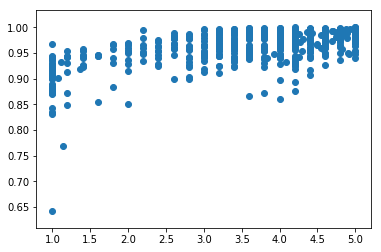

In [42]:
plt.scatter(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, 
            np.sum(sent_emb_senA*sent_emb_senB, axis=1).tolist())
# plt.ylim(0)